## Stat Stack

In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

cellstack
recursion-cellular-image-classification



In [2]:
from scipy.stats import rankdata

LABELS = ["sirna"]

In [3]:
predict_list = []
predict_list.append(pd.read_csv("../input/cellstack/submission (231).csv")[LABELS].values)
predict_list.append(pd.read_csv("../input/cellstack/submission(174).csv")[LABELS].values)
predict_list.append(pd.read_csv("../input/cellstack/submission(201).csv")[LABELS].values)

In [4]:
import warnings
warnings.filterwarnings("ignore")
print("Rank averaging on ", len(predict_list), " files")
predictions = np.zeros_like(predict_list[0])
for predict in predict_list:
    for i in range(1):
        predictions[:, i] = np.add(predictions[:, i], rankdata(predict[:, i])/predictions.shape[0])  

predictions = predictions /len(predict_list)

submission = pd.read_csv('../input/recursion-cellular-image-classification/sample_submission.csv')
submission[LABELS] = predictions
submission.to_csv('AggStacker.csv', index=False)

Rank averaging on  3  files


In [5]:
sub_path = "../input/cellstack"
all_files = os.listdir(sub_path)
all_files

['submission(201).csv', 'submission (231).csv', 'submission(174).csv']

In [6]:
import warnings
warnings.filterwarnings("ignore")
outs = [pd.read_csv(os.path.join(sub_path, f), index_col=0) for f in all_files]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "var" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)
concat_sub.head()
ncol = concat_sub.shape[1]

In [7]:
# check correlation
concat_sub.iloc[:,1:ncol].corr()

,var0,var1,var2
var0,1.000000,0.232355,0.191232
var1,0.232355,1.000000,0.195601
var2,0.191232,0.195601,1.000000


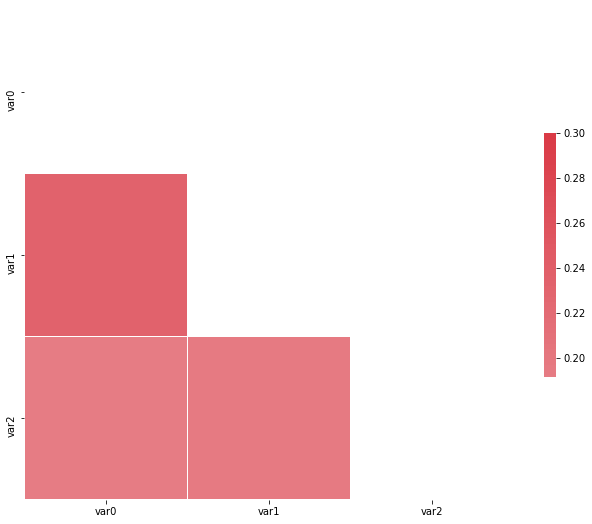

In [8]:
corr = concat_sub.iloc[:,1:7].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [9]:
# get the data fields ready for stacking
concat_sub['m_max'] = concat_sub.iloc[:, 1:ncol].max(axis=1)
concat_sub['m_min'] = concat_sub.iloc[:, 1:ncol].min(axis=1)
concat_sub['m_median'] = concat_sub.iloc[:, 1:ncol].median(axis=1)

In [10]:
concat_sub.describe()

,var0,var1,var2,m_max,m_min,m_median
count,19897.000000,19897.000000,19897.000000,19897.000000,19897.000000,19897.000000
mean,560.524200,554.542896,676.155702,832.526964,363.518319,595.177514
std,312.046642,320.031087,365.592197,280.346776,268.416673,286.727265
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,303.000000,278.000000,354.000000,656.000000,137.000000,373.000000
50%,556.000000,544.000000,704.000000,921.000000,308.000000,601.000000
75%,822.000000,835.000000,1064.000000,1089.000000,536.000000,828.000000
max,1107.000000,1107.000000,1108.000000,1108.000000,1106.000000,1107.000000


In [11]:
cutoff_lo = 0.8
cutoff_hi = 0.2

# Mean Stacking

In [12]:
rank = np.tril(concat_sub.iloc[:,1:ncol].corr().values,-1)
m_gmean = 0
m = 14
for n in range(m):
    mx = np.unravel_index(rank.argmin(), rank.shape)
    m_gmean += (m-n)*(np.log(concat_sub.iloc[:, mx[0]+1]) + np.log(concat_sub.iloc[:, mx[1]+1]))/2
    rank[mx] = 1

In [13]:
m_gmean = np.exp(m_gmean/(n-1)**2)

In [14]:
concat_sub['sirna'] = m_gmean.astype(int)
concat_sub[['id_code','sirna']].to_csv('stack_mean.csv', 
                                        index=False, float_format='%.6f')

# Median Stacking

In [15]:
concat_sub['sirna']  = concat_sub['m_median'].astype(int)
concat_sub[['id_code','sirna']].to_csv('stack_median.csv', 
                                        index=False, float_format='%.6f')

# Pushout + Median Stacking
>* Pushout strategy is bit aggresive

In [16]:
concat_sub['sirna']  = np.where(np.all(concat_sub.iloc[:,1:ncol] > cutoff_lo, axis=1), 1, 
                                    np.where(np.all(concat_sub.iloc[:,1:ncol] < cutoff_hi, axis=1),
                                             0, concat_sub['m_median']))
concat_sub[['id_code','sirna']].to_csv('stack_pushout_median.csv', 
                                        index=False, float_format='%.6f')

# MinMax + Mean Stacking
>* MinMax seems more gentle and it outperforms the previous one

In [17]:
concat_sub['m_mean'] = m_gmean.astype(int)
concat_sub['sirna']  = np.where(np.all(concat_sub.iloc[:,1:ncol] > cutoff_lo, axis=1), 
                                    concat_sub['m_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:ncol] < cutoff_hi, axis=1),
                                             concat_sub['m_min'], 
                                             concat_sub['m_mean'])).astype(int)
concat_sub[['id_code','sirna']].to_csv('stack_minmax_mean.csv', 
                                        index=False, float_format='%.6f')

# MinMax + Median Stacking

In [18]:
concat_sub['sirna'] = np.where(np.all(concat_sub.iloc[:,1:ncol] > cutoff_lo, axis=1), 
                                    concat_sub['m_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:ncol] < cutoff_hi, axis=1),
                                             concat_sub['m_min'], 
                                             concat_sub['m_median'])).astype(int)
concat_sub[['id_code','sirna']].to_csv('stack_minmax_median.csv', 
                                        index=False, float_format='%.6f')

## Averaging Ranks

In [19]:
concat_sub['sirna'] = concat_sub['var0'].rank(method ='min') + concat_sub['var1'].rank(method ='min') + concat_sub['var2'].rank(method ='min') 
concat_sub['sirna'] = (concat_sub['sirna']-concat_sub['sirna'].min())/(concat_sub['sirna'].max() - concat_sub['sirna'].min()).astype(int)
concat_sub.describe()
concat_sub[['id_code','sirna']].to_csv('stack_rank.csv', index=False, float_format='%.8f')

AttributeError: 'float' object has no attribute 'astype'